### Train with Unet

In [1]:
from utility.utils import *
from dataset.dataset import *
from dataset.transform import *
from model.loss import *
from model.unet import UNet256_3x3
from training.classifier import NucleiClassifier
from model.eval import *
from dataset.submission import *

import torch
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch.optim as optim

from skimage.morphology import label
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2
import shutil
import os

### Create Random (Stratified) Train and Validation Set - RUN AS NEEDED

In [2]:
classes = pd.read_csv('classes.csv')
train_dirs, valid_dirs = get_stratified_valid_dirs(classes, seed=17)

In [3]:
main_path = '../data/ds_bowl_2018/'
full_path = '../data/ds_bowl_2018/full_data/'

In [ ]:
create_validation_dirs(main_path, full_path, None, train_dirs, valid_dirs)

In [ ]:
# test distribution
classes[~classes.is_train].groupby(['foreground', 'background']).count()

In [ ]:
# distributions seem similar to test
classes[classes.filename.isin([f + '.png' for f in valid_dirs])].groupby(['foreground', 'background']).count()

### Training

In [4]:
train_path = '../data/ds_bowl_2018/train/'
valid_path = '../data/ds_bowl_2018/valid/'

58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd.png


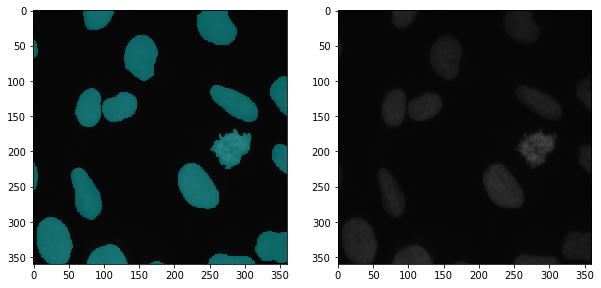

8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832.png


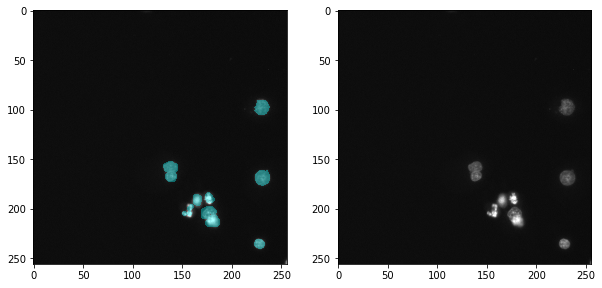

c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730cbf031de174bf437b7.png


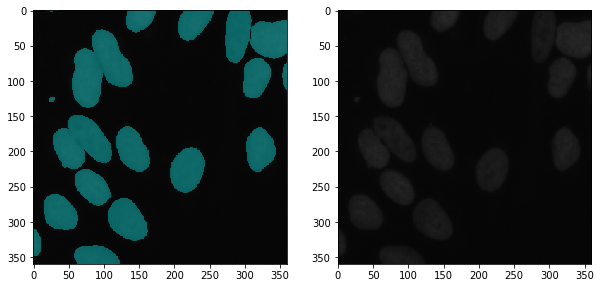

5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8.png


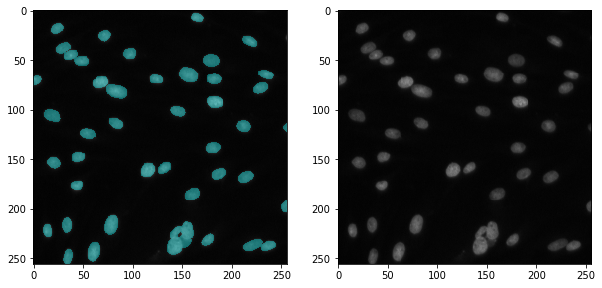

2f929b067a59f88530b6bfa6f6889bc3a38adf88d594895973d1c8b2549fd93d.png


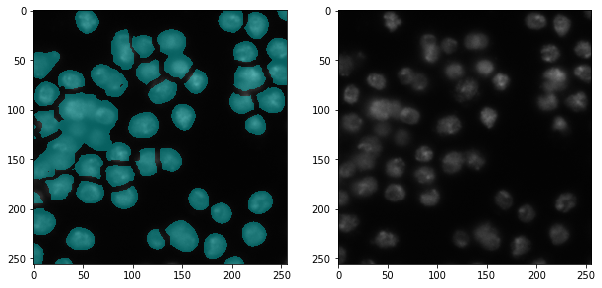

In [5]:
# Look at training images
image_mask_paths = get_image_onemask_paths(train_path)
for img_path , mask_path in image_mask_paths[:5]:
    show_image(img_path, mask_path, figsize=(10, 10))

2dd9d8c797fc695665326fc8fd0eb5cd292139fa478ccb5acb7fb352f7030063.png


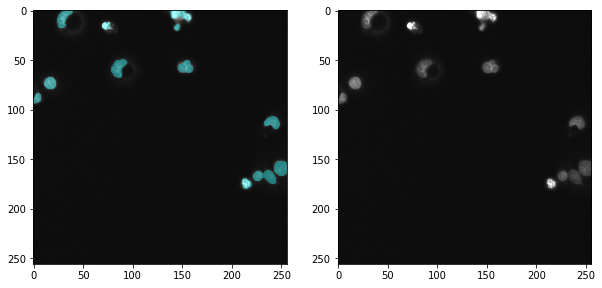

fc5452f612a0f972fe55cc677055ede662af6723b5c1615ad539b8a4bd279bdb.png


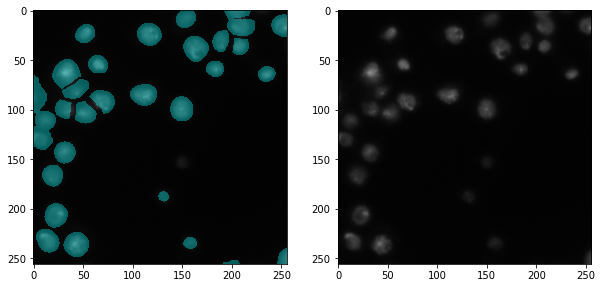

f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5.png


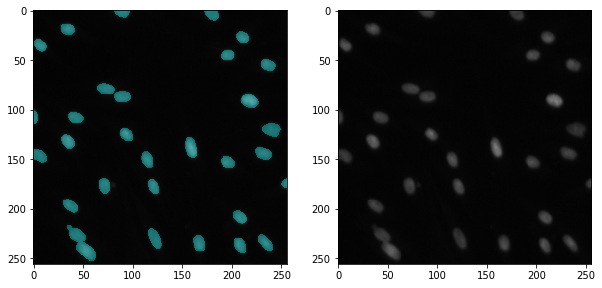

4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1.png


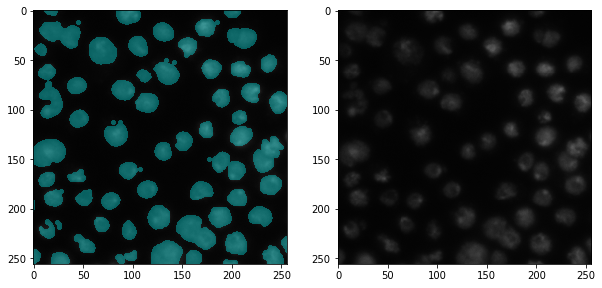

c00ae67f72816daee468474026e30705003b2d3501f123579a4f0a6366b66aa1.png


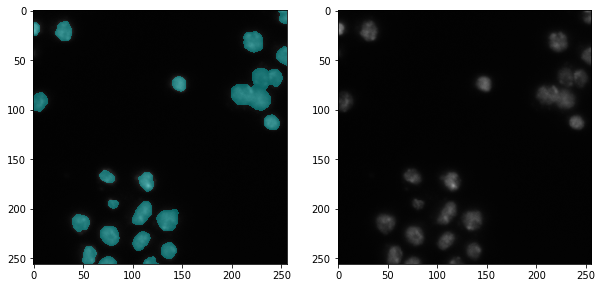

In [6]:
# Look at validation images
image_mask_paths = get_image_onemask_paths(valid_path)
for img_path , mask_path in image_mask_paths[:5]:
    show_image(img_path, mask_path, figsize=(10, 10))

### Training

In [7]:
def train_augment(image, mask, index, sz = 256):        
    # do some data augmentation
    image, mask = random_horizontal_flip_transform2(image, mask)
    image, mask = random_vertical_flip_transform2(image, mask)
    #image, mask = random_rotate_transform2(image, mask)
    #image, mask = random_crop_resize2(image, mask, 0.1)
    
    # resize image for Unet256
    image, mask = fix_resize_transform2(image, mask, sz, sz)
    
    # normalize pixel intensities 
    # get dimensions right
    image = (image.transpose((2,0,1))) / 255 #shift channel axis to axis 0 and normalize
    mask = mask[None, :] / 255 # create binary mask
    
    return image.astype(np.float64), mask.astype(np.float64), index

def valid_augment(image, mask, index, sz = 256):        
    # resize image for Unet256
    image, mask = fix_resize_transform2(image, mask, sz, sz)
    
    # normalize pixel intensities 
    # get dimensions right
    image = (image.transpose((2,0,1))) / 255 #shift channel axis to axis 0 and normalize
    mask = mask[None, :] / 255 # create binary mask
    
    return image.astype(np.float64), mask.astype(np.float64), index

def test_augment(image, mask, index, sz = 256):
    # resize image for Unet256
    image = fix_resize_transform(image, sz, sz)
    # normalize pixel intensities
    image = (image.transpose((2,0,1))) / 255 
    return image.astype(np.float64), index

In [8]:
# create trainloader
trn_ds = NucleiDataset('../data/ds_bowl_2018/train/', transform=train_augment, mode='train')
trn_dl = DataLoader(trn_ds, batch_size=8, shuffle=True)
# create validloader
val_ds = NucleiDataset('../data/ds_bowl_2018/valid/', transform=valid_augment, mode='valid')
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)
# create testloader
test_ds = NucleiDataset('../data/ds_bowl_2018/test/', transform=test_augment, mode='test')
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [ ]:
classifier._criterion(logits, V(targets).cuda())

In [12]:
# training definition
net = UNet256_3x3(in_shape=(3, 256, 256), num_classes=1).double()
#optimizer = optim.Adam(net.parameters(), lr=0.1)
optimizer = optim.RMSprop(net.parameters(), lr=0.01)
#criterion
crit = BCELoss2d()

In [13]:
# init classifier
classifier = NucleiClassifier(net, 1000)

In [ ]:
# train for 10 epochs
classifier.train(train_loader=trn_dl, valid_loader=val_dl, optimizer=optimizer,crit=crit, epochs=20, threshold=0.5)

In [ ]:
# train for 10 epochs
classifier.train(train_loader=trn_dl, valid_loader=val_dl, optimizer=optimizer,crit=crit, epochs=20, threshold=0.5)

In [ ]:
# train for 10 epochs
classifier.train(train_loader=trn_dl, valid_loader=val_dl, optimizer=optimizer,crit=crit, epochs=20, threshold=0.5)

In [15]:
# save model and optimizer
# model can be 
classifier.save_model('../data/ds_bowl_2018/models/unet256_model60', '../data/ds_bowl_2018/models/unet256_optim60')

## Visualize Evaluation

In [16]:
# load pretrained net
classifier.restore_model('../data/ds_bowl_2018/models/unet256_model50')

In [17]:
params = list(classifier.net.parameters())

In [21]:
classifier.net

UNet256_3x3(
  (down1): Sequential(
    (0): Conv2d (3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down2): Sequential(
    (0): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down3): Sequential(
    (0): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (256, 512, kernel_si

### Training

		 Image 					 Mask 				 Predicted Mask


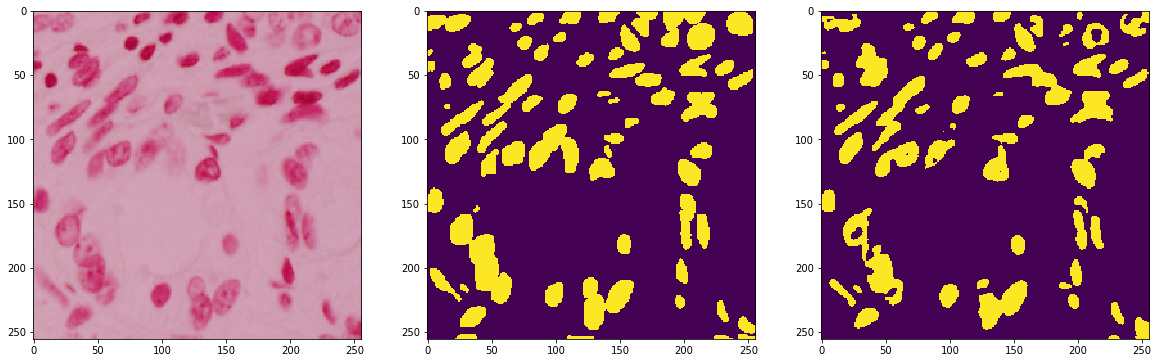

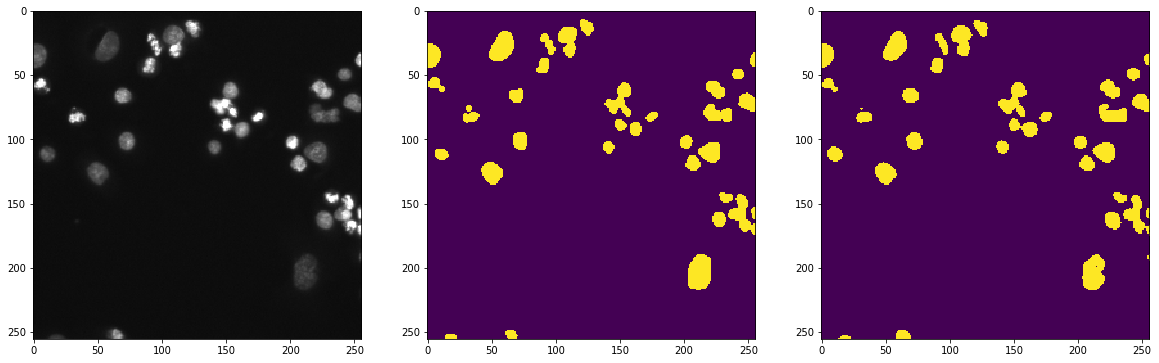

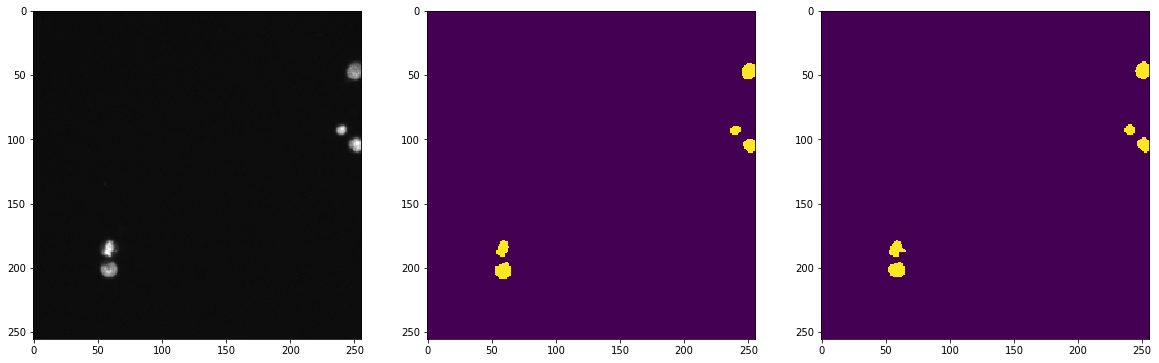

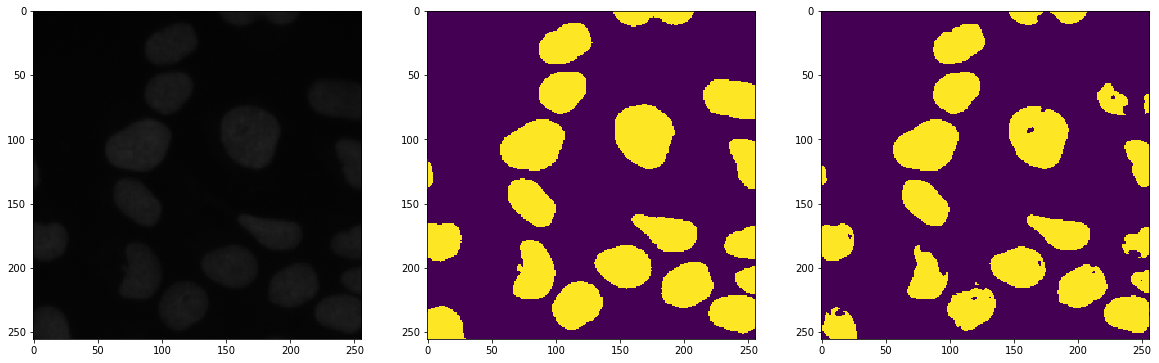

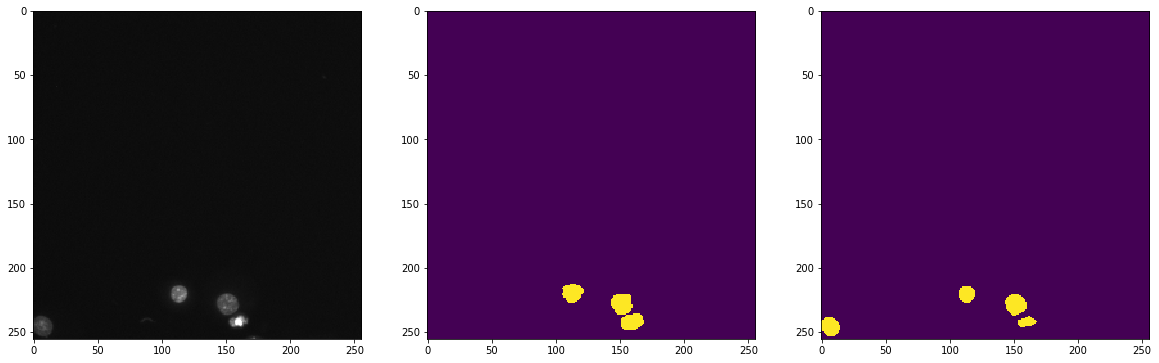

In [17]:
show_predictions(trn_dl, classifier, 0.5, 5)

### Validation

		 Image 					 Mask 				 Predicted Mask


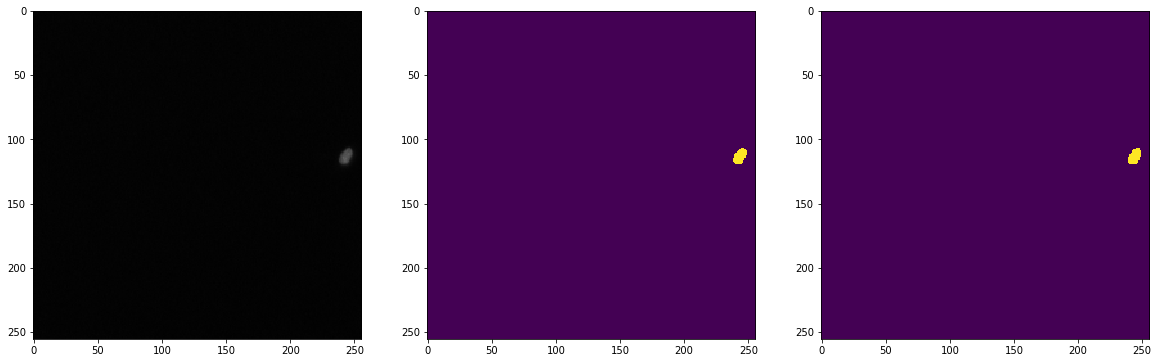

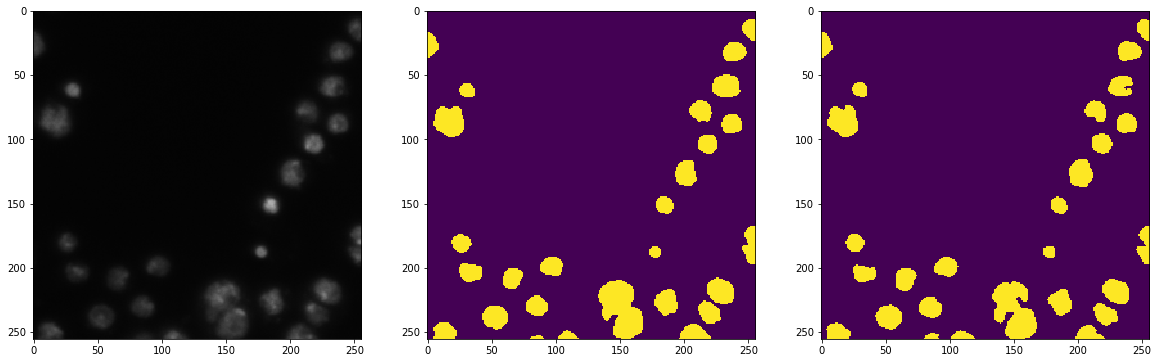

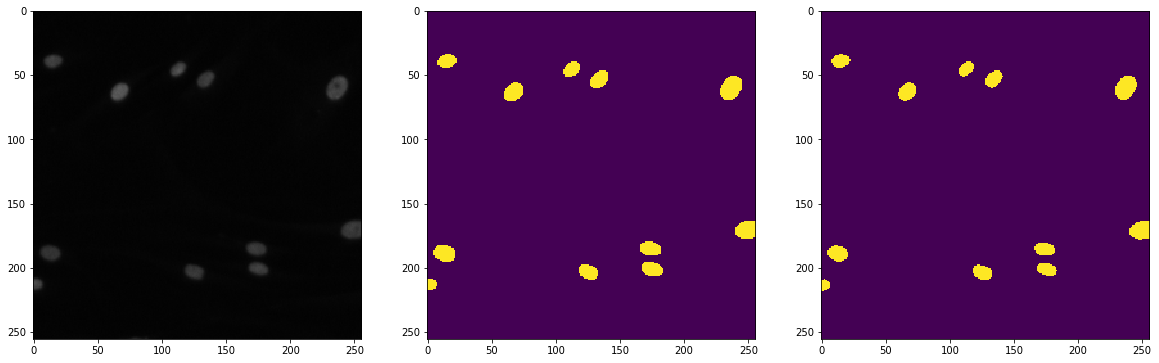

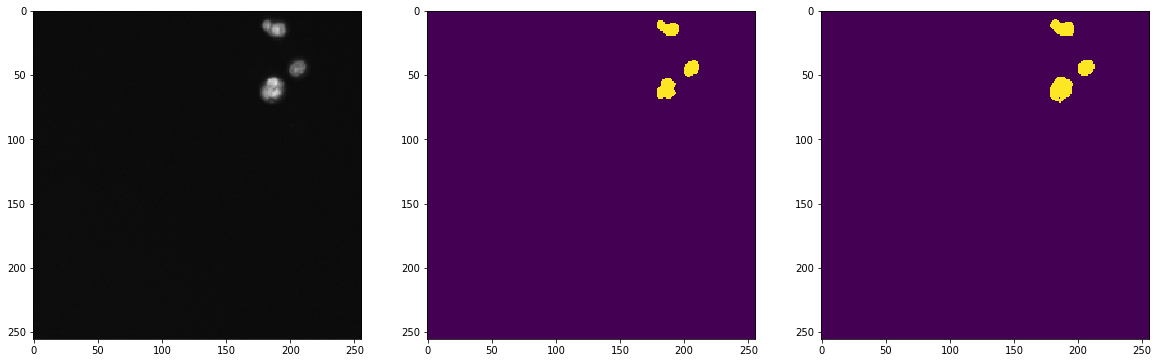

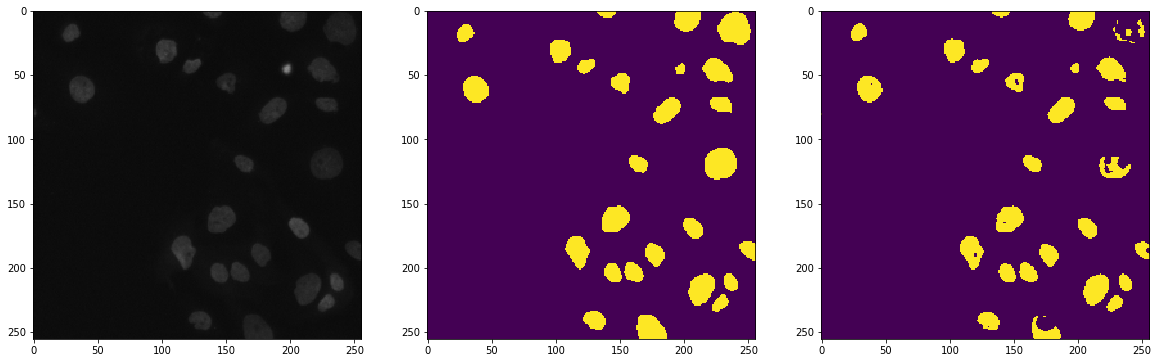

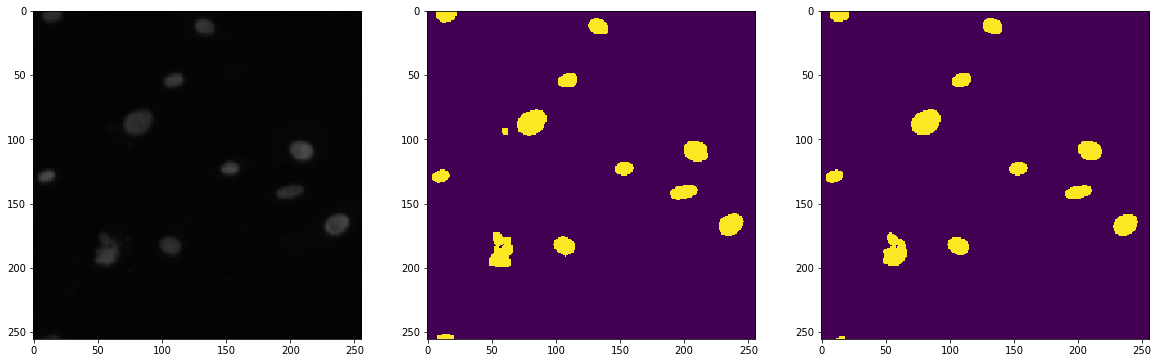

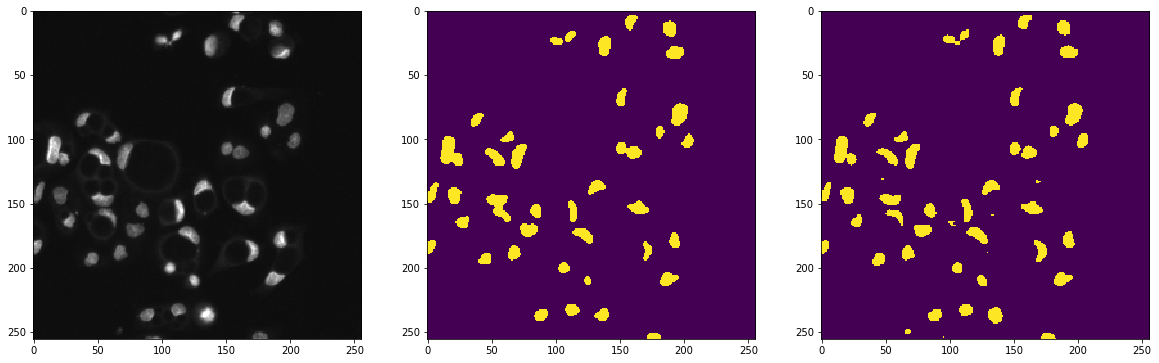

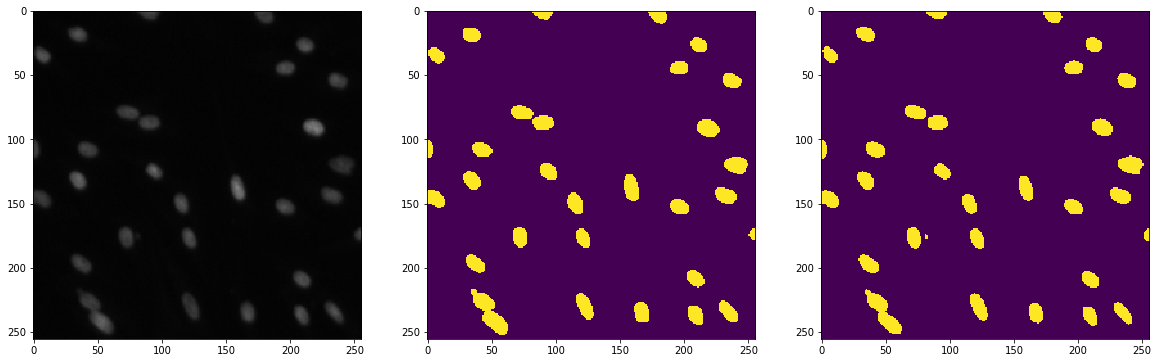

In [18]:
show_predictions(val_dl, classifier, 0.5, n=10)

### Test

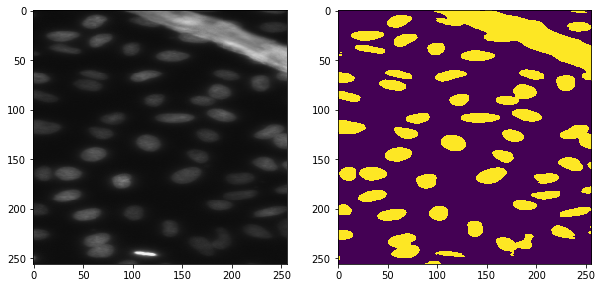

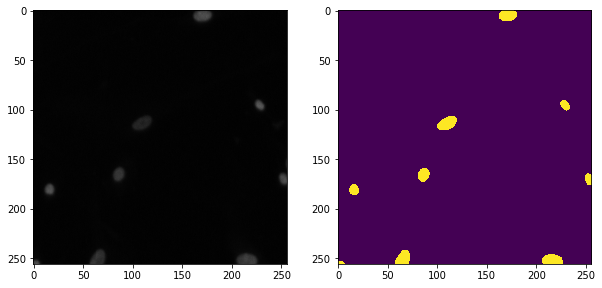

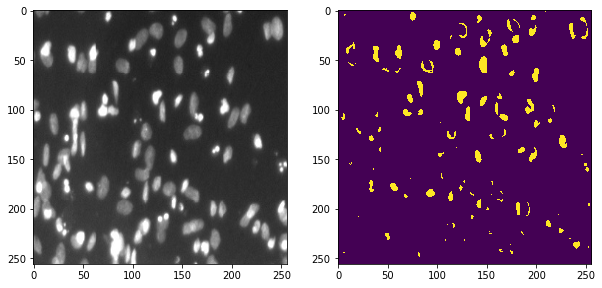

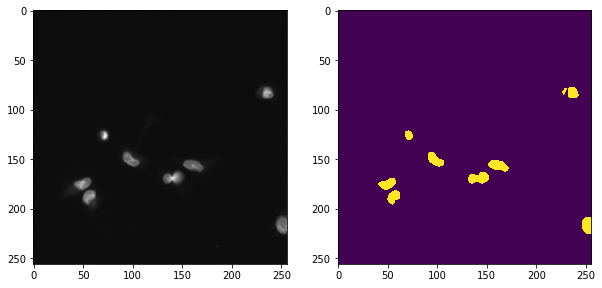

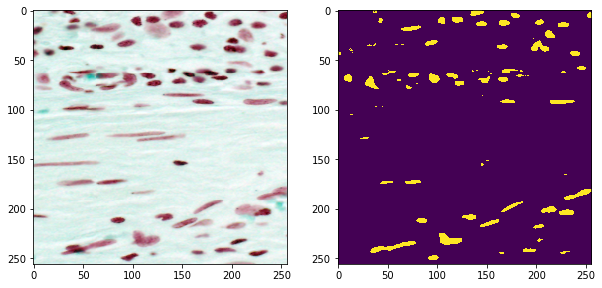

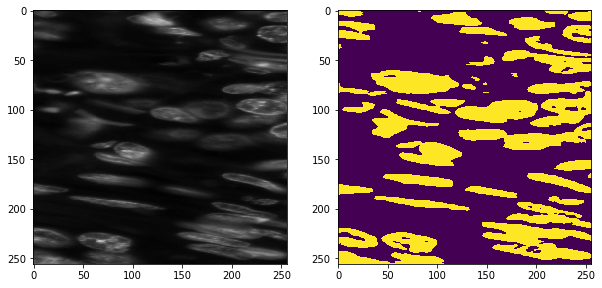

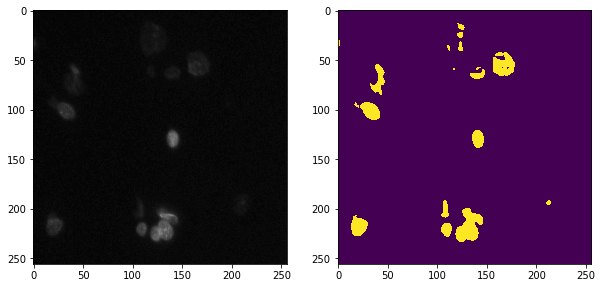

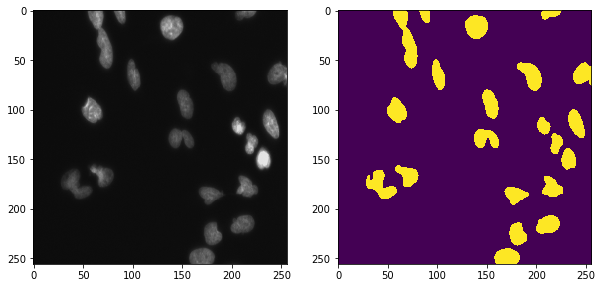

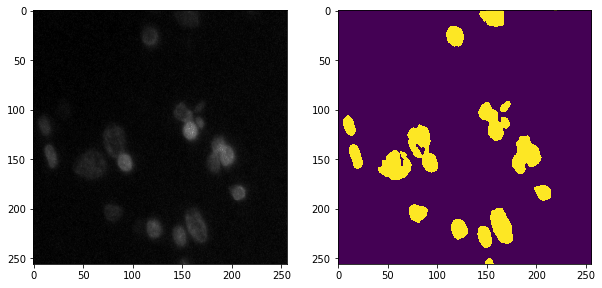

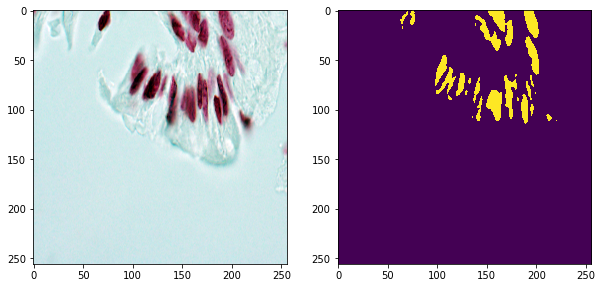

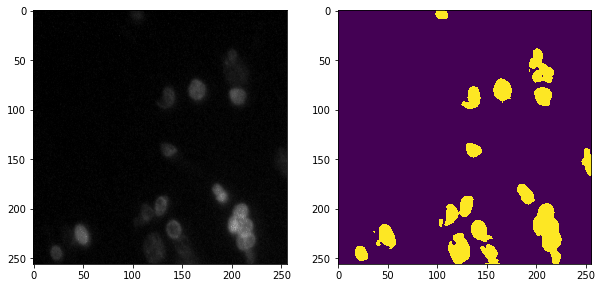

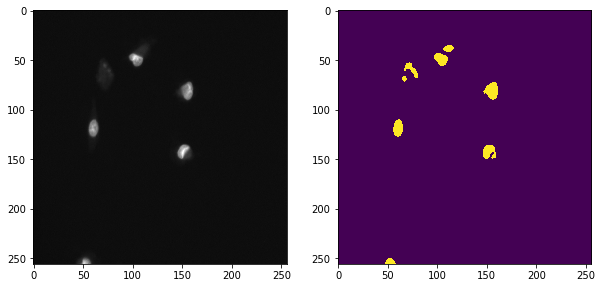

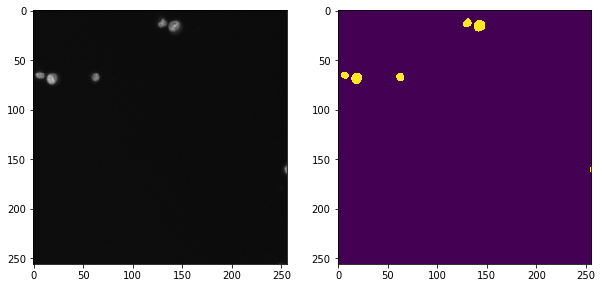

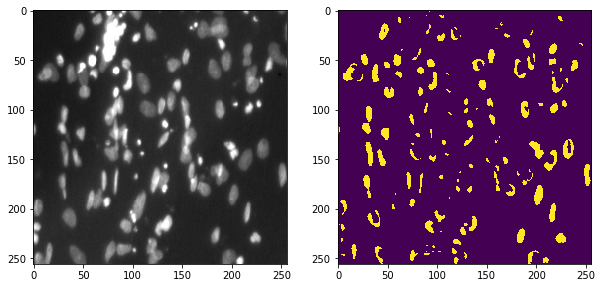

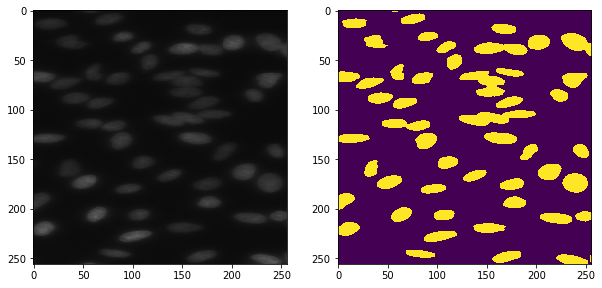

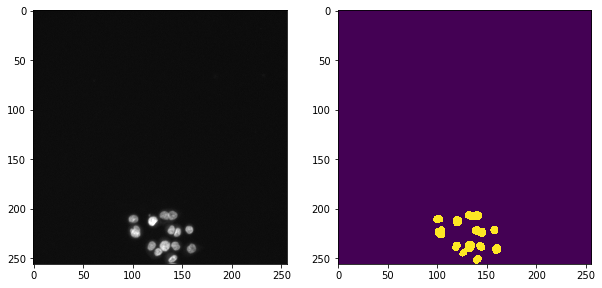

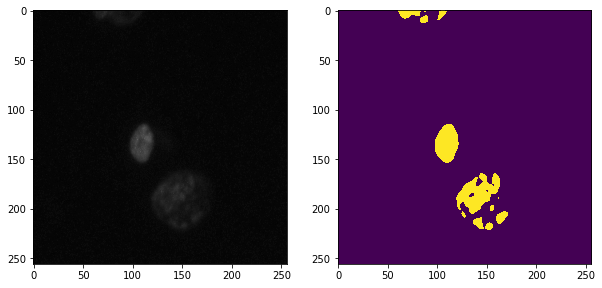

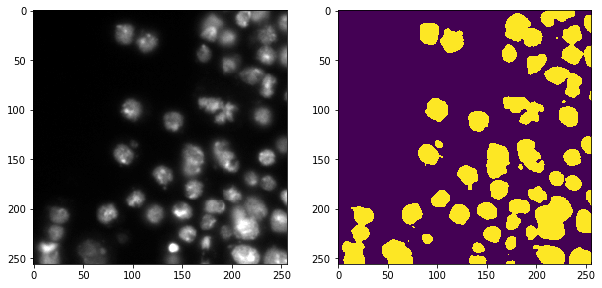

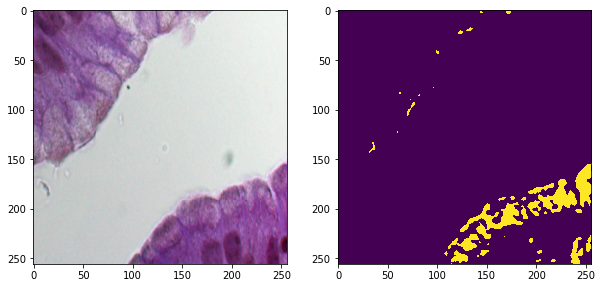

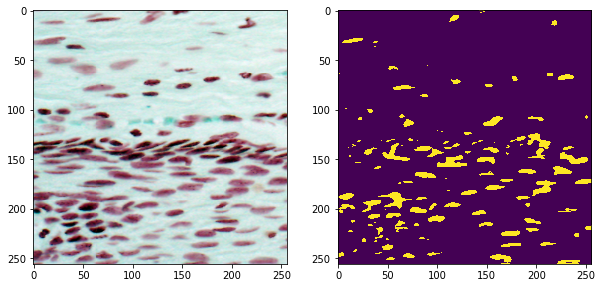

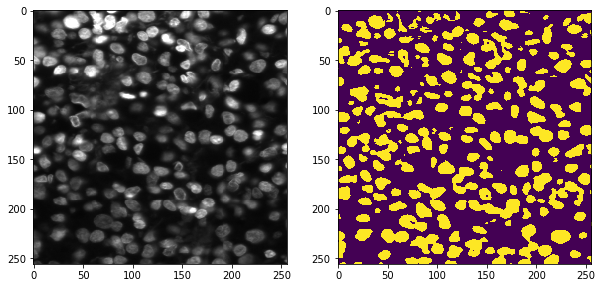

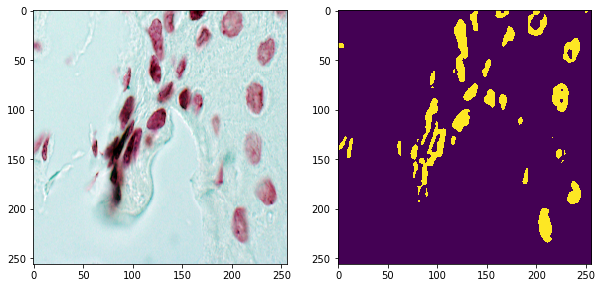

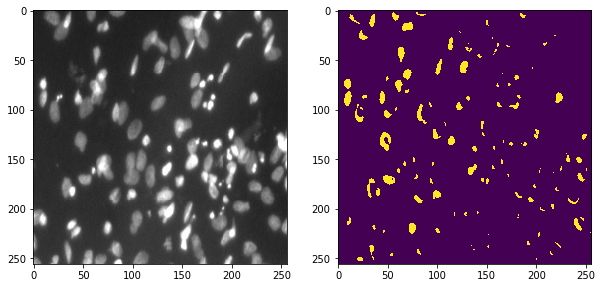

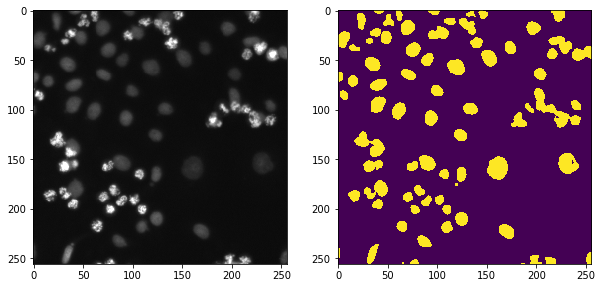

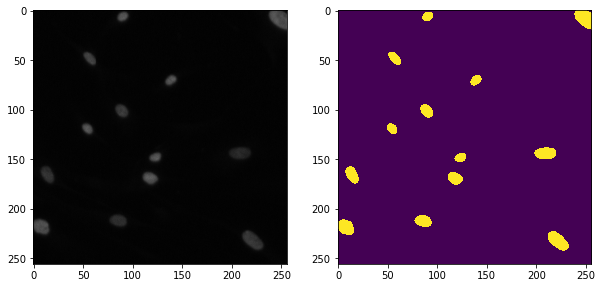

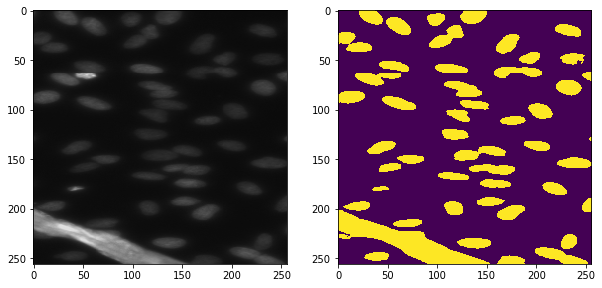

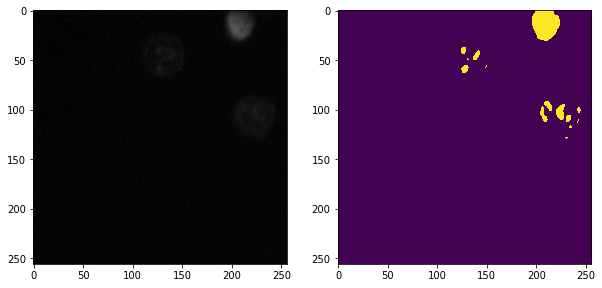

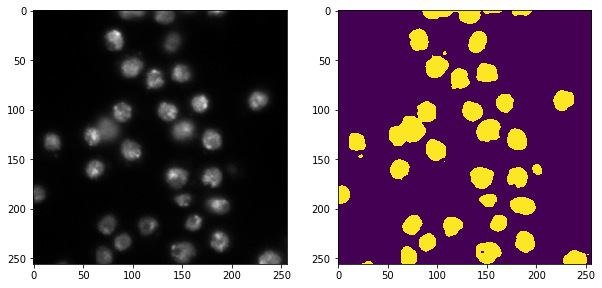

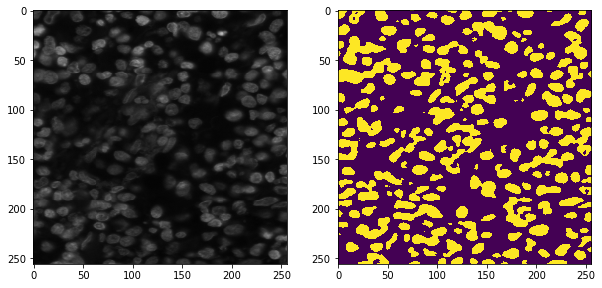

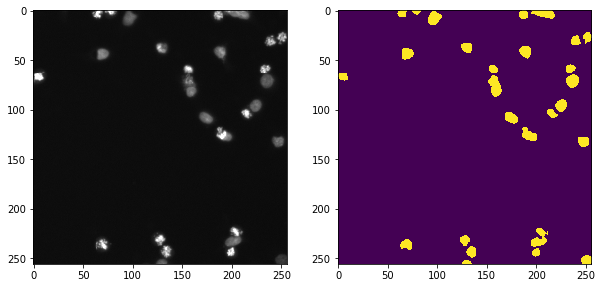

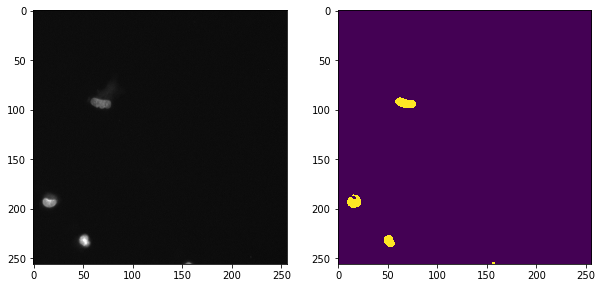

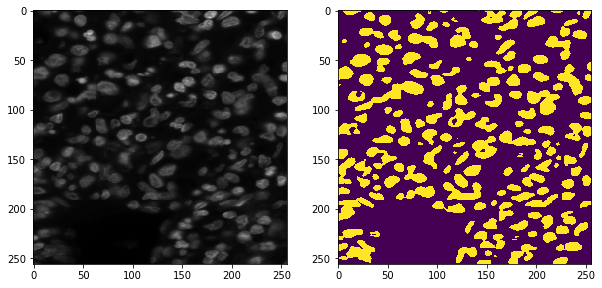

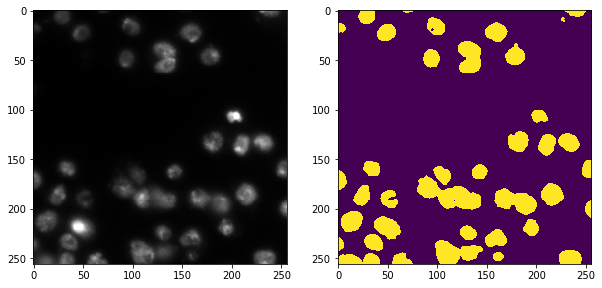

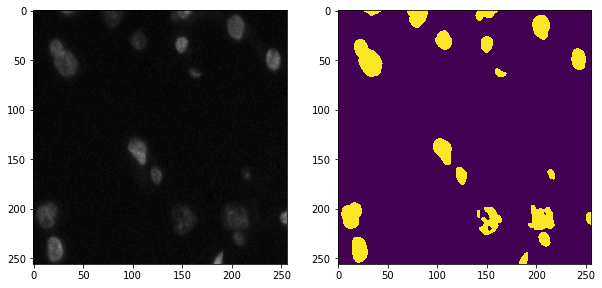

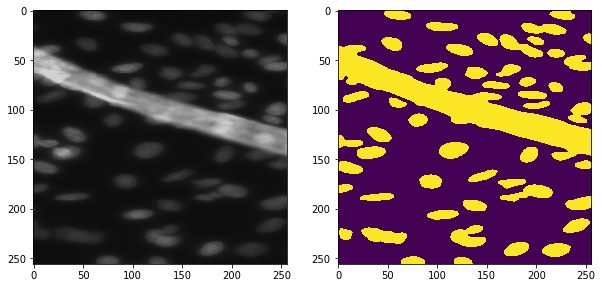

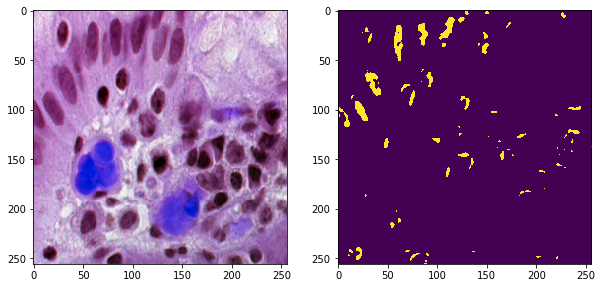

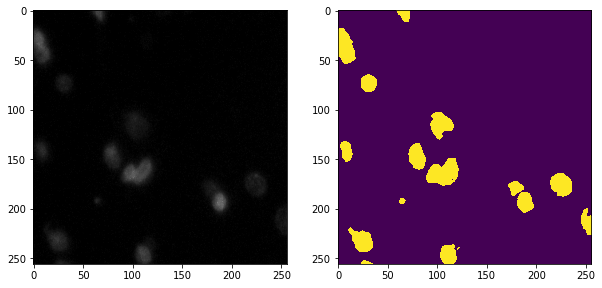

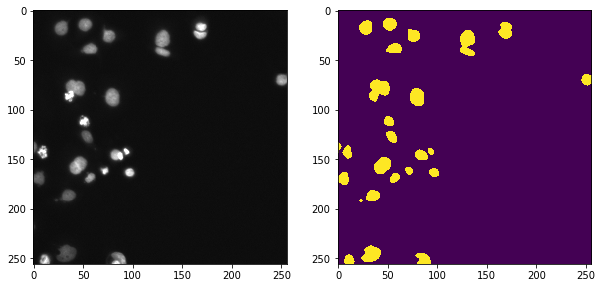

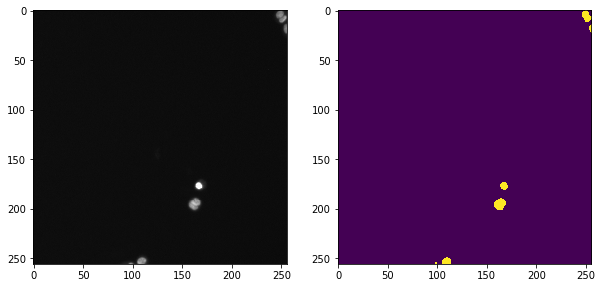

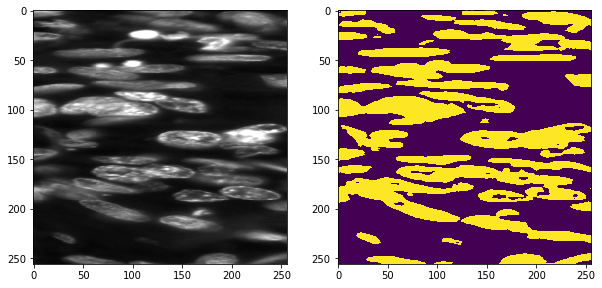

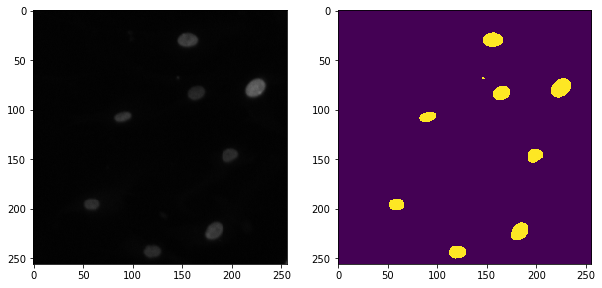

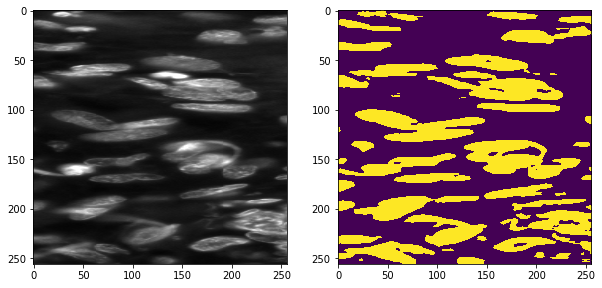

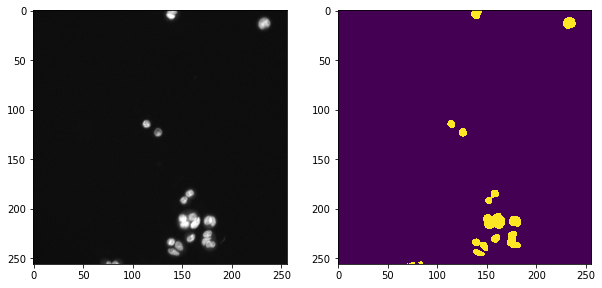

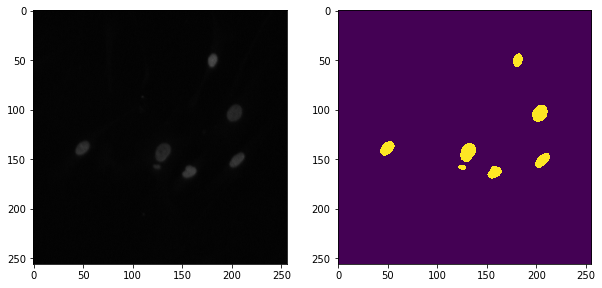

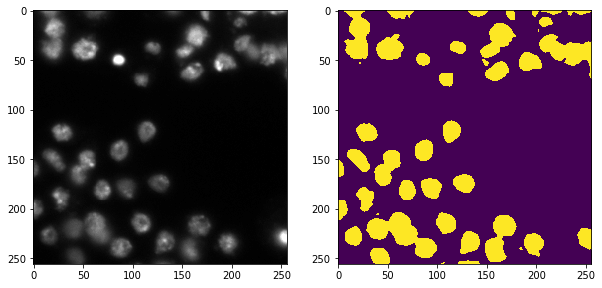

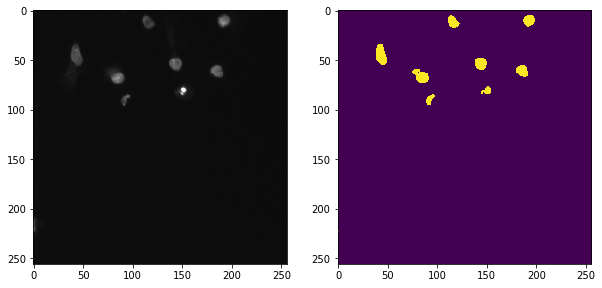

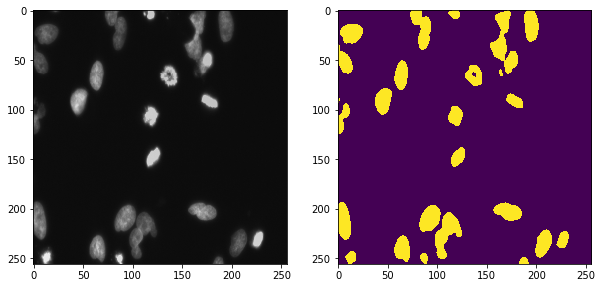

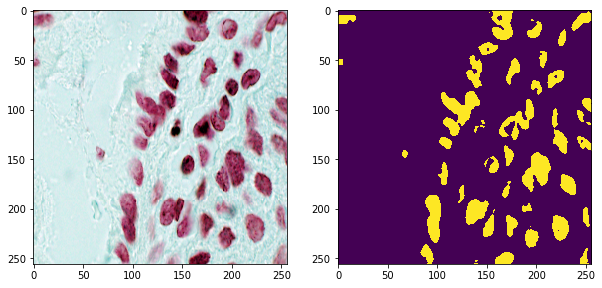

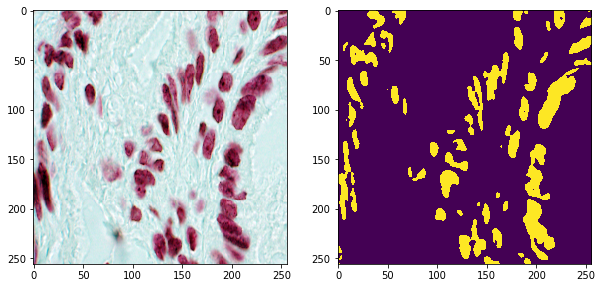

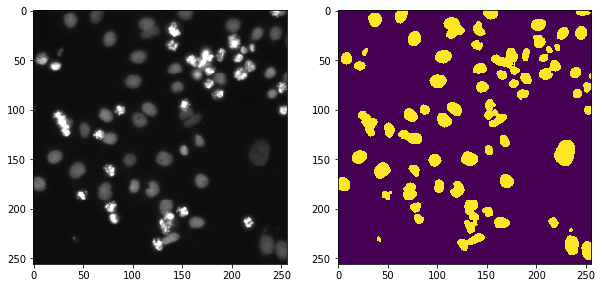

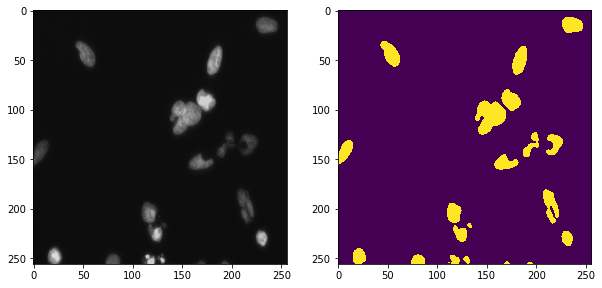

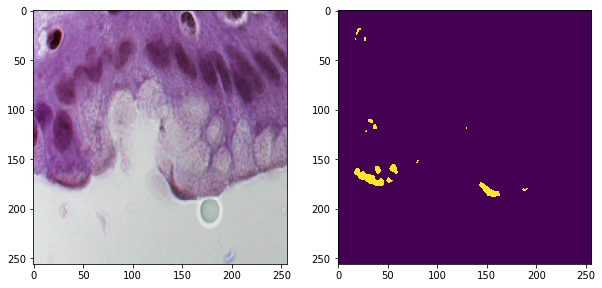

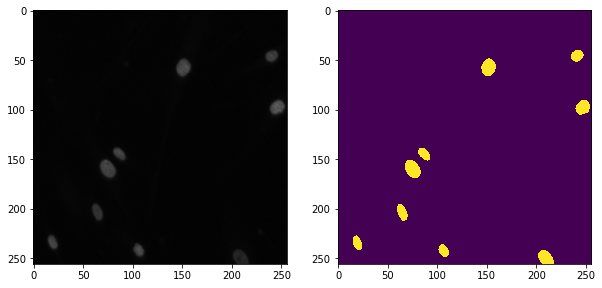

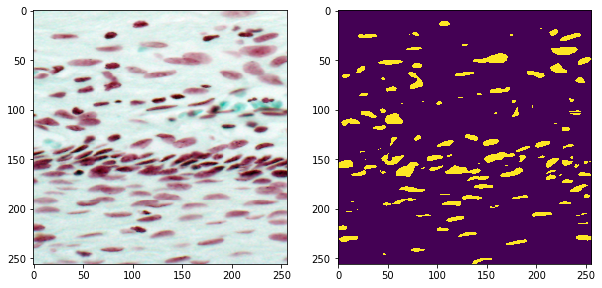

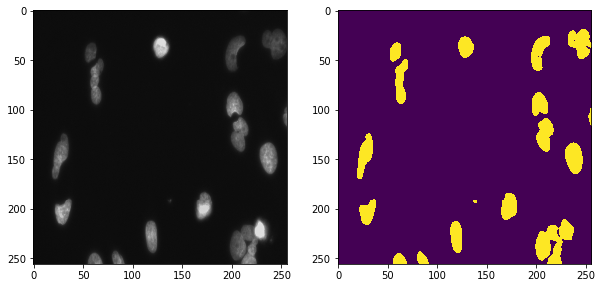

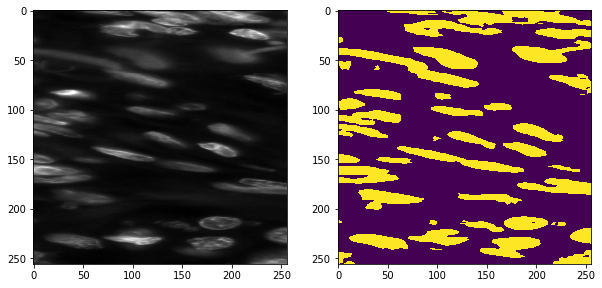

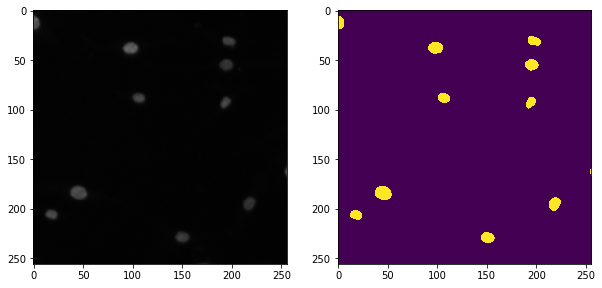

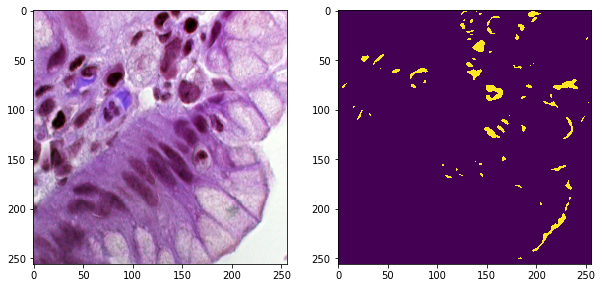

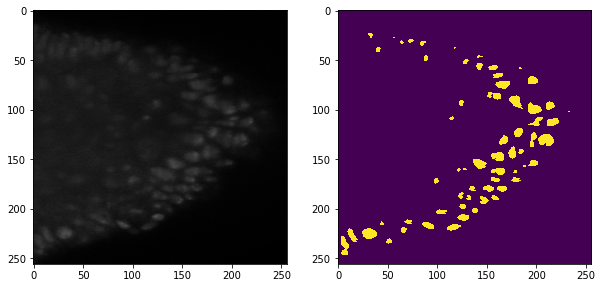

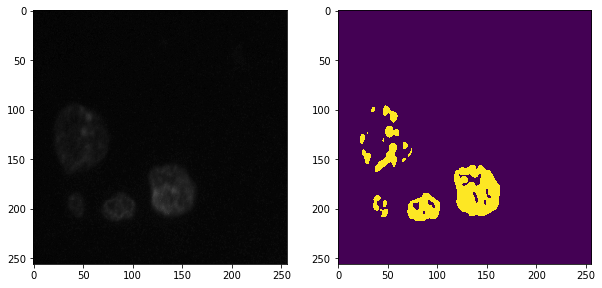

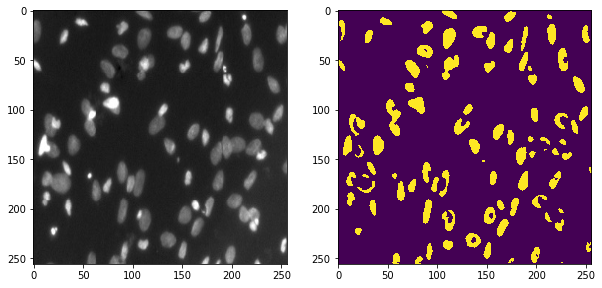

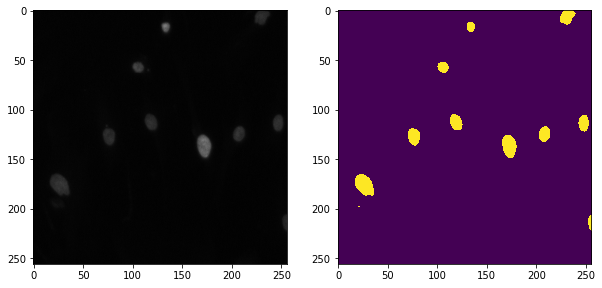

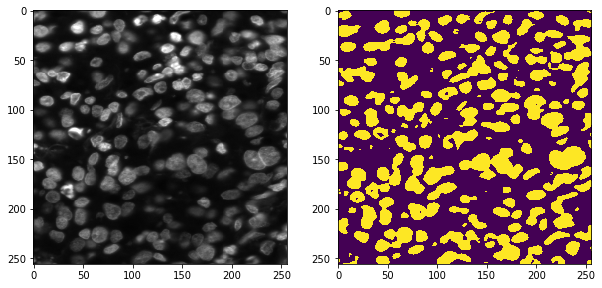

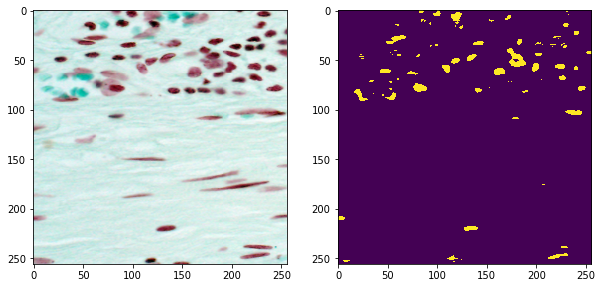

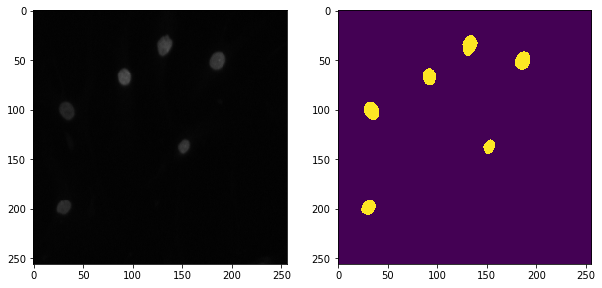

In [37]:
show_test_predictions(test_dl, classifier)

### Make Predictions

In [81]:
# make predictions
preds = classifier.predict(test_dl)

In [82]:
# resize predictions
test_sz = []
for fpath in test_ds.image_dirs:
    fname = fpath + 'images/' + fpath.split('/')[-2] + '.png'
    h, w = cv2.imread(fname, cv2.IMREAD_GRAYSCALE).shape
    test_sz.append((w, h))

preds = [cv2.resize(pred[0, 0], test_sz[i]) for i, pred in enumerate(preds)]

In [90]:
from skimage.morphology import label
label(preds[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [91]:
def predict_and_submit(preds, test_ds):    
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ds.image_dirs):
        id_ = id_.split('/')[-2]
        rle = list(prob_to_rles(preds[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    return sub

In [92]:
sub_df = predict_and_submit(preds, test_ds)

In [96]:
sub_df.shape

(3019, 2)

In [97]:
sub_df.to_csv('../data/ds_bowl_2018/submissions/unet_basic.csv', index=False)

In [98]:
from IPython.display import FileLink

In [99]:
FileLink('../data/ds_bowl_2018/submissions/unet_basic.csv')

/home/ubuntu/deeplearning/data/ds_bowl_2018/submissions/unet_basic.csv